In [129]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
import matplotlib.pyplot as plt

In [130]:
stations = pd.read_csv('data\clean\hourly_uniformly_azk.csv')
stations.head()

,time,kWh,Latitude,Longitude,InternalNum
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100


In [131]:
locations = pd.read_csv('data\locations.csv')
locations.head()

,Unnamed: 0,Унікод АЗС,Address,Number,Region,Latitude,Longitude
0,0,28410100.0,"м. Київ, просп. Леся Курбаса, 2 Ж",АЗС-47,м. Київ,50.43104,30.39037
1,1,25840200.0,"м. Київ, вул. Новокостянтинівська, 4 Ж",АЗС-62,м. Київ,50.48207,30.48725
2,2,40112300.0,"м. Стрий, вул. Болехівська, 49",АЗС-23,Львів,49.24778,23.85610
3,3,40512100.0,"Надвірнянський р-н, м. Надвірна, вул. Вокзальн...",АЗС-21,Івано-Франківськ,48.62307,24.58351
4,4,60961300.0,"м. Київ, просп. Академіка Палладіна, 33",АЗС-63,м. Київ,50.46754,30.35680


In [132]:
distinct_values = locations['Region'].unique()
print("Distinct values:", distinct_values)

Distinct values: ['м. Київ' 'Львів' 'Івано-Франківськ' 'Дніпропетровськ' 'Київ' 'Харків'
 'Чернівецька' 'Одеса' 'Черкаси' 'Закарпаття' 'Рівне' 'Кіровоград'
 'Полтава' 'Житомир' 'Волинь']


In [133]:
joined = pd.merge(stations, locations, left_on='InternalNum', right_on='Унікод АЗС', how='inner')
columns_to_select = ['time', 'kWh', 'Latitude_x', 'Longitude_x', 'InternalNum', 'Region']
final_df = joined[columns_to_select]
final_df.head()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100,м. Київ
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100,м. Київ
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100,м. Київ


<font>
<font size = '10'>
<center><b>Київ</b></center></font>

In [134]:
kyiv_stations = final_df[(final_df['Region'] == 'м. Київ') | (final_df['Region'] == 'Київ')]
lviv_stations = final_df[final_df['Region'] == 'Львів']
ivano_frankivsk_stations = final_df[final_df['Region'] == 'Івано-Франківськ']
dnipro_stations = final_df[final_df['Region'] == 'Дніпропетровськ']
kharkiv_stations = final_df[final_df['Region'] == 'Харків']
chernivtsi_stations = final_df[final_df['Region'] == 'Чернівецька']
odesa_stations = final_df[final_df['Region'] == 'Одеса']
cherkasy_stations = final_df[final_df['Region'] == 'Черкаси']
zakarpatya_stations = final_df[final_df['Region'] == 'Закарпаття']
rivne_stations = final_df[final_df['Region'] == 'Рівне']
kropyvnytskyi_stations = final_df[final_df['Region'] == 'Кіровоград']
poltava_stations = final_df[final_df['Region'] == 'Полтава']
zhytomyr_stations = final_df[final_df['Region'] == 'Житомир']
volyn_stations = final_df[final_df['Region'] == 'Волинь']

In [135]:
kyiv_stations.head()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100,м. Київ
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100,м. Київ
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100,м. Київ


In [136]:
kyiv_stations['time'] = pd.to_datetime(kyiv_stations['time'])

kyiv_stations['year'] = kyiv_stations['time'].dt.year
kyiv_stations['month'] = kyiv_stations['time'].dt.month
kyiv_stations['day'] = kyiv_stations['time'].dt.day
kyiv_stations['day_of_week'] = kyiv_stations['time'].dt.weekday
kyiv_stations['hour'] = kyiv_stations['time'].dt.hour

kyiv_stations.tail()

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_stations['time'] = pd.to_datetime(kyiv_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_stations['year'] = kyiv_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region,year,month,day,day_of_week,hour
1535291,2024-10-31 03:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,3
1535292,2024-10-31 04:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,4
1535293,2024-10-31 05:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,5
1535294,2024-10-31 06:00:00,32.52,50.34903,30.95535,40861000,Київ,2024,10,31,3,6
1535295,2024-10-31 07:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,7


In [158]:
# Filter for test (October 2024)
test_kyiv = kyiv_stations[(kyiv_stations['time'].dt.year == 2024) & (kyiv_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_kyiv = kyiv_stations[(kyiv_stations['time'].dt.year == 2024) & (kyiv_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_kyiv = kyiv_stations[kyiv_stations['time'] < '2024-09-01']

In [161]:
features = ['Latitude_x', 'Longitude_x', 'year', 'month', 'day', 'day_of_week', 'hour']
target = 'kWh'

In [162]:
X_train = train_kyiv[features]
y_train = train_kyiv[target]

X_valid = validation_kyiv[features]
y_valid = validation_kyiv[target]

In [165]:
train_kyiv = kyiv_stations[(kyiv_stations['time'] > '2023-01-01') & (kyiv_stations['time'] < '2024-09-01')]
X_train = train_kyiv[features]
y_train = train_kyiv[target]

In [168]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "tree_method": "auto",
        "n_jobs": 4,
    }

    # Train the XGBoost model
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train, verbose=0)

    # Predict and calculate RMSE
    valid_preds = xgb_model.predict(X_valid)
    valid_preds = np.clip(valid_preds, 0, None)
    rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
    return rmse

# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-18 14:21:05,852] A new study created in memory with name: no-name-5ca9806c-2724-4a93-8291-54c76a8f39a2
[I 2024-12-18 14:21:13,242] Trial 0 finished with value: 13.610399652011802 and parameters: {'n_estimators': 900, 'max_depth': 15, 'learning_rate': 0.20377477203834815, 'subsample': 0.9914190179360798, 'colsample_bytree': 0.5579593768866424, 'gamma': 5.121732391518359, 'lambda': 0.9292493229287873, 'alpha': 0.0011445784799115105}. Best is trial 0 with value: 13.610399652011802.
[I 2024-12-18 14:21:15,118] Trial 1 finished with value: 13.277456352547585 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1787333531983465, 'subsample': 0.7423859061611819, 'colsample_bytree': 0.5965657078617561, 'gamma': 5.060529360208981, 'lambda': 0.017836593529798977, 'alpha': 0.005665218248410595}. Best is trial 1 with value: 13.277456352547585.
[I 2024-12-18 14:21:18,134] Trial 2 finished with value: 13.92687901955515 and parameters: {'n_estimators': 150, 'max_depth':

Best Parameters: {'n_estimators': 950, 'max_depth': 7, 'learning_rate': 0.011781208234133991, 'subsample': 0.9017204832961636, 'colsample_bytree': 0.8662349319719226, 'gamma': 0.14398388510385818, 'lambda': 0.051006380713928, 'alpha': 1.999661254232635}
Optimized XGB RMSE: 13.144296565850714


In [169]:
X_test = test_kyiv[features]
y_test = test_kyiv[target]

In [170]:
def xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test):
    xgb_model = xgb.XGBRegressor(**study.best_params)
    xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]), verbose=0)

    test_preds = xgb_model.predict(X_test)
    test_preds = np.clip(test_preds, 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f'Test RMSE: {rmse}')
    return test_preds

kyiv_preds = xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 13.742693093774042


In [181]:
test_kyiv = test_kyiv.reset_index()

In [186]:
kyiv_preds_df = pd.DataFrame(kyiv_preds, columns=['preds'])
kyiv_preds_df['unicode'] = test_kyiv['InternalNum']
kyiv_preds_df['time'] = test_kyiv['time']
kyiv_preds_df.head()

,preds,unicode,time
0,0.880527,28410100,2024-10-01 00:00:00
1,0.000000,28410100,2024-10-01 01:00:00
2,0.000000,28410100,2024-10-01 02:00:00
3,0.000000,28410100,2024-10-01 03:00:00
4,0.000000,28410100,2024-10-01 04:00:00


In [202]:
distinct_kyiv = test_kyiv['InternalNum'].unique()

In [208]:
kyiv_station_rmse = {}

for station in distinct_kyiv:
    cut_preds = kyiv_preds_df[kyiv_preds_df['unicode'] == station]
    cut_test = test_kyiv[test_kyiv['InternalNum'] == station]
    rmse = np.sqrt(mean_squared_error(cut_preds['preds'], cut_test['kWh']))
    kyiv_station_rmse[station] = rmse

# Sort stations by RMSE
sorted_stations = sorted(kyiv_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

Best RMSE: 0.6822 (Station: 40860600)
Median RMSE: 7.7285 (Station: 25840200)
Worst RMSE: 24.1942 (Station: 40810700)


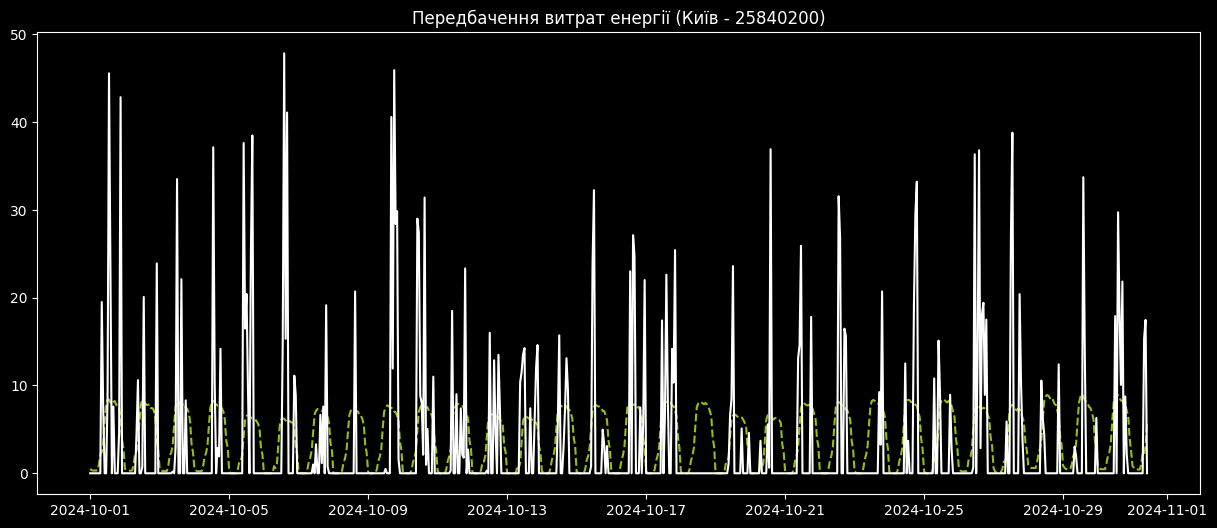

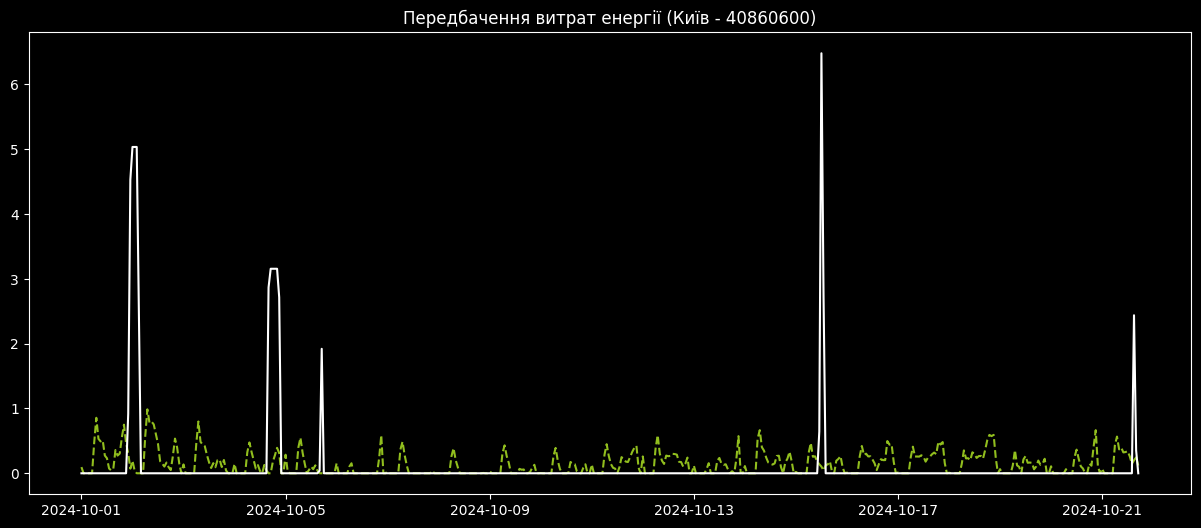

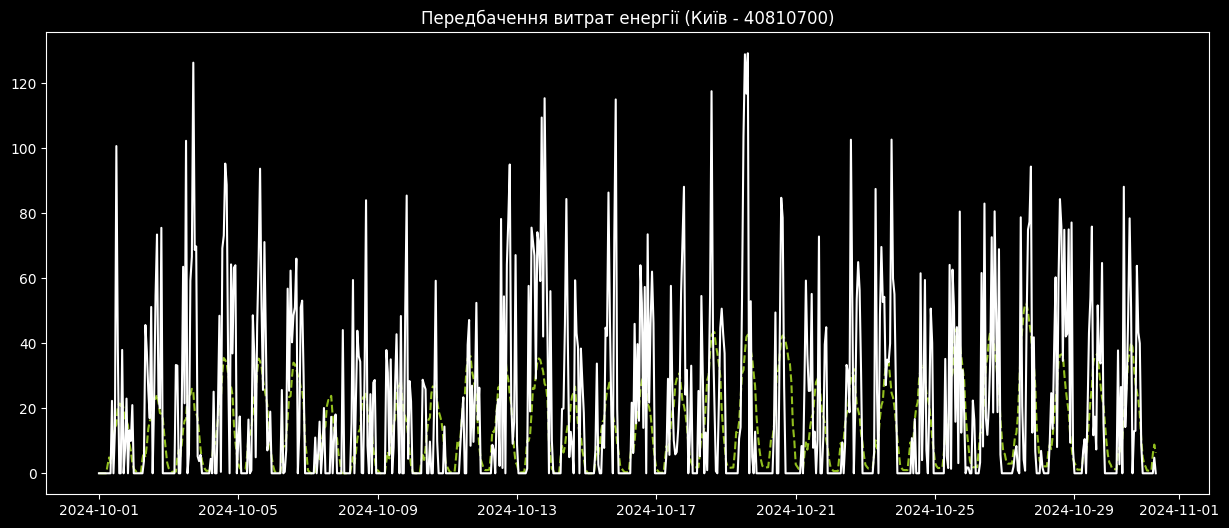

In [212]:
cut_preds_median = kyiv_preds_df[kyiv_preds_df['unicode'] == median_station]
cut_test_median = test_kyiv[test_kyiv['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Київ - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = kyiv_preds_df[kyiv_preds_df['unicode'] == best_station]
cut_test_median = test_kyiv[test_kyiv['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Київ - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = kyiv_preds_df[kyiv_preds_df['unicode'] == worst_station]
cut_test_median = test_kyiv[test_kyiv['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Київ - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')

<font>
<font size = '10'>
<center><b>Львів</b></center></font>

In [223]:
lviv_stations['time'] = pd.to_datetime(lviv_stations['time'])

lviv_stations['year'] = lviv_stations['time'].dt.year
lviv_stations['month'] = lviv_stations['time'].dt.month
lviv_stations['day'] = lviv_stations['time'].dt.day
lviv_stations['day_of_week'] = lviv_stations['time'].dt.weekday
lviv_stations['hour'] = lviv_stations['time'].dt.hour

lviv_stations.tail()

# Filter for test (October 2024)
test_lviv = lviv_stations[(lviv_stations['time'].dt.year == 2024) & (lviv_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_lviv = lviv_stations[(lviv_stations['time'].dt.year == 2024) & (lviv_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_lviv = lviv_stations[(lviv_stations['time'] > '2023-01-01') & (lviv_stations['time'] < '2024-09-01')]

X_train = train_lviv[features]
y_train = train_lviv[target]

X_valid = validation_lviv[features]
y_valid = validation_lviv[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\4123132933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lviv_stations['time'] = pd.to_datetime(lviv_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\4123132933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lviv_stations['year'] = lviv_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\4123132933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [224]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-18 15:12:58,608] A new study created in memory with name: no-name-a88e8345-8d12-4fb8-af93-415362f7c4d2
[I 2024-12-18 15:13:02,494] Trial 0 finished with value: 15.486164466554149 and parameters: {'n_estimators': 850, 'max_depth': 8, 'learning_rate': 0.15043482673104833, 'subsample': 0.8992021563706158, 'colsample_bytree': 0.6507330636375435, 'gamma': 0.4320621305741368, 'lambda': 0.7425895739578202, 'alpha': 4.824134870315848}. Best is trial 0 with value: 15.486164466554149.
[I 2024-12-18 15:13:06,006] Trial 1 finished with value: 15.27595955253351 and parameters: {'n_estimators': 850, 'max_depth': 8, 'learning_rate': 0.11820273755439485, 'subsample': 0.8683404754768875, 'colsample_bytree': 0.6610073473201865, 'gamma': 2.9783953100810026, 'lambda': 0.02197244821328148, 'alpha': 8.178475517224705}. Best is trial 1 with value: 15.27595955253351.
[I 2024-12-18 15:13:07,864] Trial 2 finished with value: 15.301513816352891 and parameters: {'n_estimators': 600, 'max_depth': 5, 'le

Best Parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.01943626496056583, 'subsample': 0.6915301559475364, 'colsample_bytree': 0.5980466176813537, 'gamma': 4.47605114130621, 'lambda': 0.010817010943997124, 'alpha': 0.6117026777139137}
Optimized XGB RMSE: 14.712712981074862


In [225]:
def xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test):
    xgb_model = xgb.XGBRegressor(**study.best_params)
    xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]), verbose=0)

    test_preds = xgb_model.predict(X_test)
    test_preds = np.clip(test_preds, 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f'Test RMSE: {rmse}')
    return test_preds

In [226]:
X_test = test_lviv[features]
y_test = test_lviv[target]

lviv_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 16.541371840384347


Best RMSE: 0.4720 (Station: 40111700)
Median RMSE: 18.6103 (Station: 40113200)
Worst RMSE: 25.1219 (Station: 40162800)


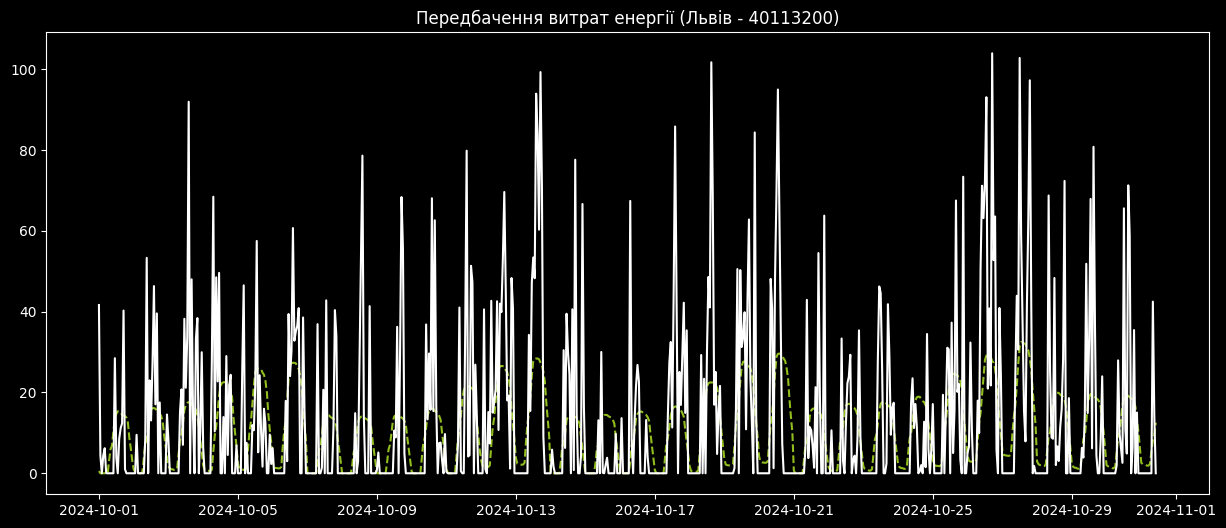

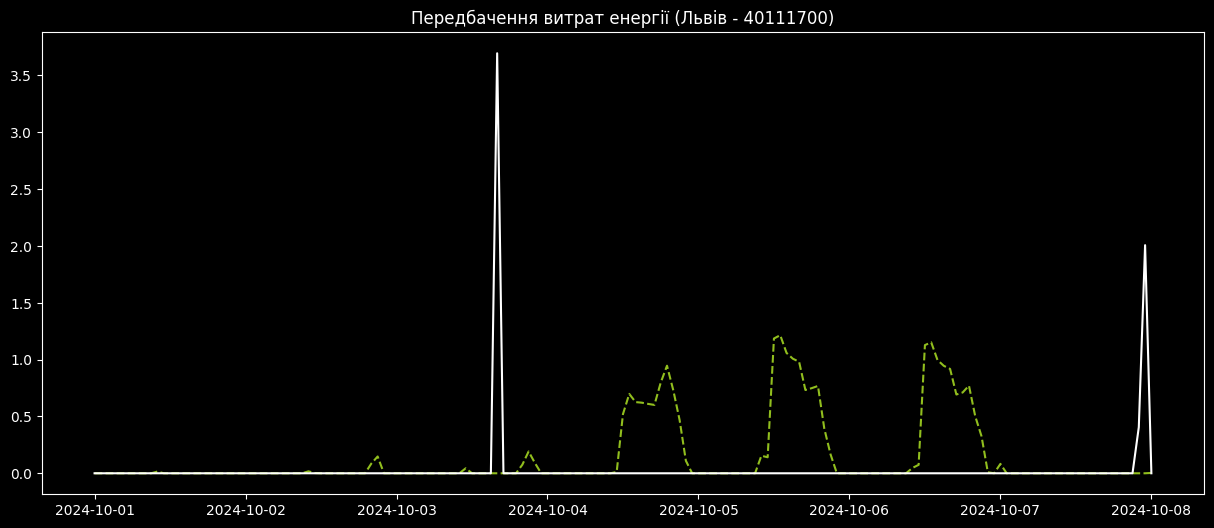

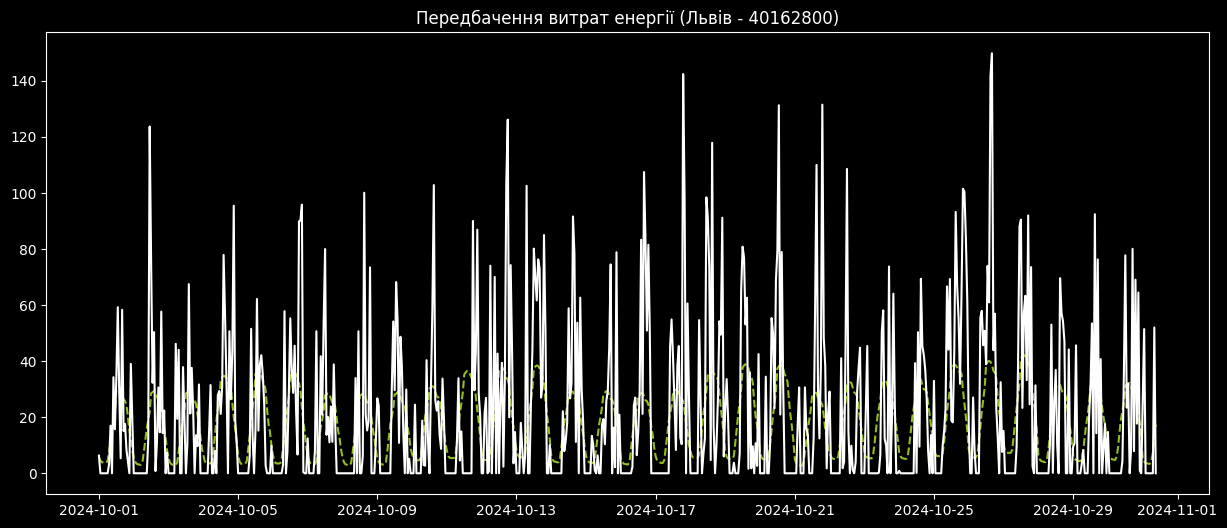

In [227]:
test_lviv = test_lviv.reset_index()
lviv_preds_df = pd.DataFrame(lviv_preds, columns=['preds'])
lviv_preds_df['unicode'] = test_lviv['InternalNum']
lviv_preds_df['time'] = test_lviv['time']
distinct_lviv = test_lviv['InternalNum'].unique()

lviv_station_rmse = {}

for station in distinct_lviv:
    cut_preds = lviv_preds_df[lviv_preds_df['unicode'] == station]
    cut_test = test_lviv[test_lviv['InternalNum'] == station]
    rmse = np.sqrt(mean_squared_error(cut_preds['preds'], cut_test['kWh']))
    lviv_station_rmse[station] = rmse

# Sort stations by RMSE
sorted_stations = sorted(lviv_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = lviv_preds_df[lviv_preds_df['unicode'] == median_station]
cut_test_median = test_lviv[test_lviv['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Львів - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = lviv_preds_df[lviv_preds_df['unicode'] == best_station]
cut_test_median = test_lviv[test_lviv['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Львів - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = lviv_preds_df[lviv_preds_df['unicode'] == worst_station]
cut_test_median = test_lviv[test_lviv['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Львів - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')


<font>
<font size = '10'>
<center><b>Дніпро</b></center></font>

In [228]:
dnipro_stations['time'] = pd.to_datetime(dnipro_stations['time'])

dnipro_stations['year'] = dnipro_stations['time'].dt.year
dnipro_stations['month'] = dnipro_stations['time'].dt.month
dnipro_stations['day'] = dnipro_stations['time'].dt.day
dnipro_stations['day_of_week'] = dnipro_stations['time'].dt.weekday
dnipro_stations['hour'] = dnipro_stations['time'].dt.hour

dnipro_stations.tail()

# Filter for test (October 2024)
test_dnipro = dnipro_stations[(dnipro_stations['time'].dt.year == 2024) & (dnipro_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_dnipro = dnipro_stations[(dnipro_stations['time'].dt.year == 2024) & (dnipro_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_dnipro = dnipro_stations[(dnipro_stations['time'] > '2023-01-01') & (dnipro_stations['time'] < '2024-09-01')]

X_train = train_dnipro[features]
y_train = train_dnipro[target]

X_valid = validation_dnipro[features]
y_valid = validation_dnipro[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\2100384852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dnipro_stations['time'] = pd.to_datetime(dnipro_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\2100384852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dnipro_stations['year'] = dnipro_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\2100384852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [229]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-18 15:37:23,754] A new study created in memory with name: no-name-d98a86d4-8afc-4118-ad7c-453d9ca0fe9f
[I 2024-12-18 15:37:23,890] Trial 0 finished with value: 1.26385917088865 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.18176055565490362, 'subsample': 0.6156212994318442, 'colsample_bytree': 0.9376138585260537, 'gamma': 1.2379588443949308, 'lambda': 0.5636821097889464, 'alpha': 4.740796966391336}. Best is trial 0 with value: 1.26385917088865.
[I 2024-12-18 15:37:24,339] Trial 1 finished with value: 1.1977856062538568 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.12856271424644033, 'subsample': 0.5845128520687163, 'colsample_bytree': 0.7221025839796495, 'gamma': 4.100777607847148, 'lambda': 0.005131395849680796, 'alpha': 0.12400824548594921}. Best is trial 1 with value: 1.1977856062538568.
[I 2024-12-18 15:37:24,556] Trial 2 finished with value: 1.156469402889473 and parameters: {'n_estimators': 250, 'max_depth': 3, 'l

Best Parameters: {'n_estimators': 550, 'max_depth': 12, 'learning_rate': 0.14162378179514015, 'subsample': 0.500715158555632, 'colsample_bytree': 0.5403774255183573, 'gamma': 5.194651026087979, 'lambda': 0.01633665962120408, 'alpha': 0.013137406574688298}
Optimized XGB RMSE: 1.1487059769424546


In [233]:
X_test = test_dnipro[features]
y_test = test_dnipro[target]

dnipro_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 1.0904168140769281


Best RMSE: 0.3610 (Station: 23460100)
Median RMSE: 1.3578 (Station: 41264000)
Worst RMSE: 1.3578 (Station: 41264000)


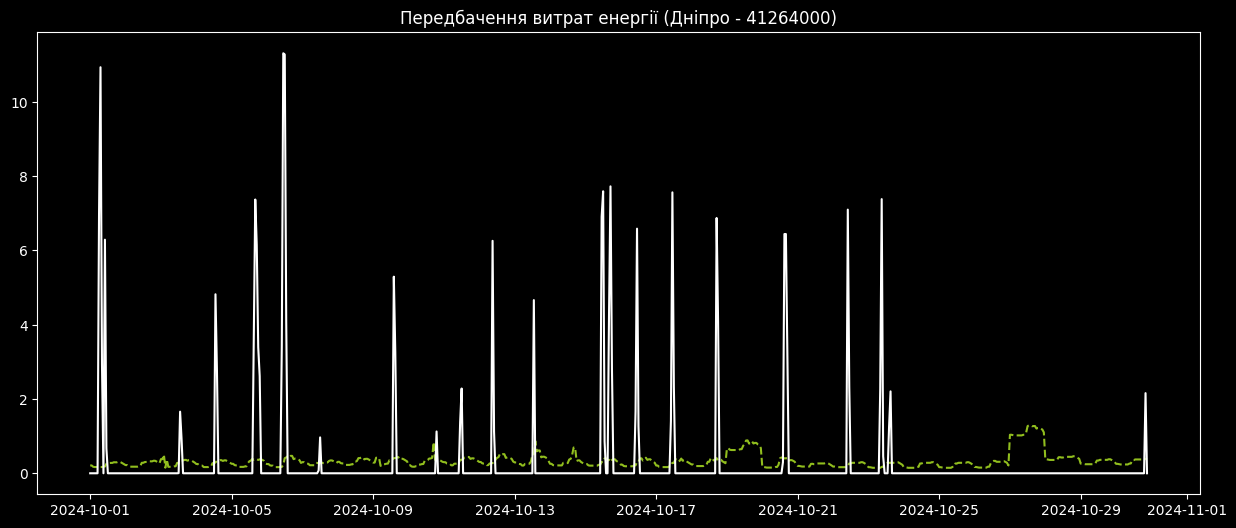

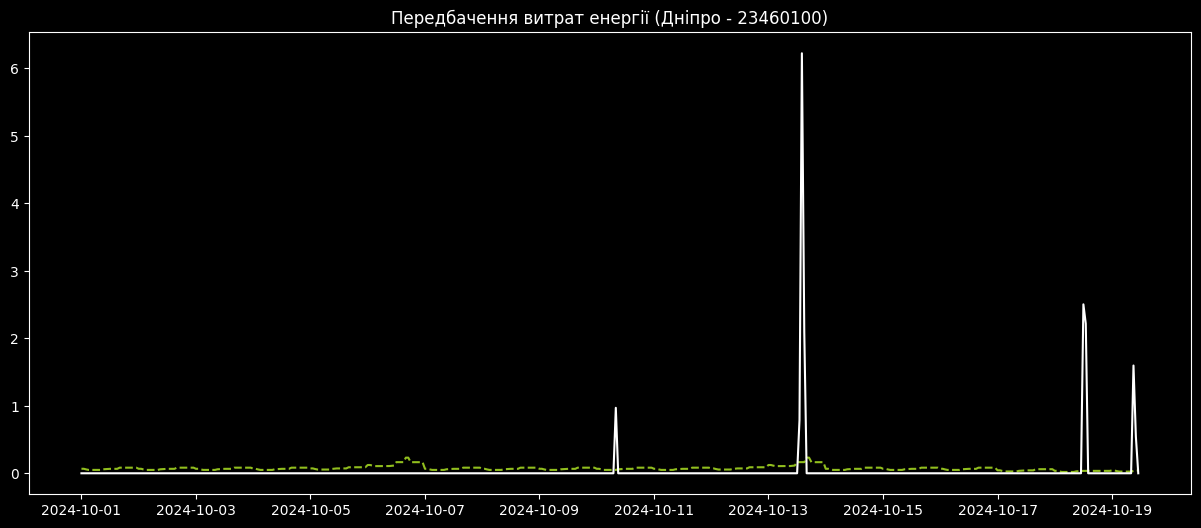

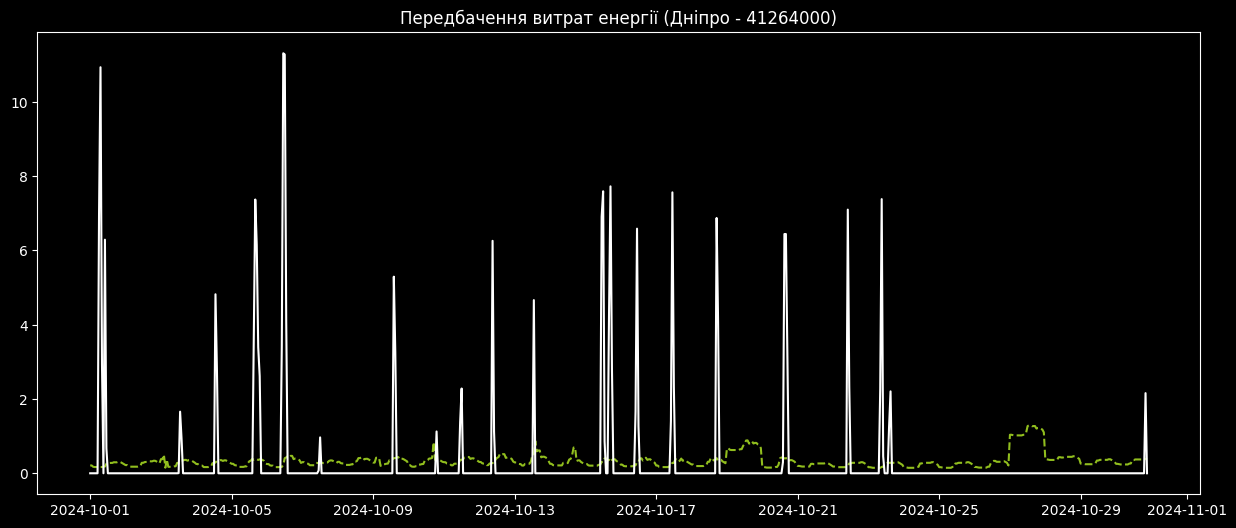

In [234]:
test_dnipro = test_dnipro.reset_index()
dnipro_preds_df = pd.DataFrame(dnipro_preds, columns=['preds'])
dnipro_preds_df['unicode'] = test_dnipro['InternalNum']
dnipro_preds_df['time'] = test_dnipro['time']
distinct_dnipro = test_dnipro['InternalNum'].unique()

dnipro_station_rmse = {}

for station in distinct_dnipro:
    cut_preds = dnipro_preds_df[dnipro_preds_df['unicode'] == station]
    cut_test = test_dnipro[test_dnipro['InternalNum'] == station]
    rmse = np.sqrt(mean_squared_error(cut_preds['preds'], cut_test['kWh']))
    dnipro_station_rmse[station] = rmse

# Sort stations by RMSE
sorted_stations = sorted(dnipro_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = dnipro_preds_df[dnipro_preds_df['unicode'] == median_station]
cut_test_median = test_dnipro[test_dnipro['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Дніпро - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = dnipro_preds_df[dnipro_preds_df['unicode'] == best_station]
cut_test_median = test_dnipro[test_dnipro['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Дніпро - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = dnipro_preds_df[dnipro_preds_df['unicode'] == worst_station]
cut_test_median = test_dnipro[test_dnipro['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Дніпро - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')


<font>
<font size = '10'>
<center><b>Одеса</b></center></font>

In [236]:
odesa_stations['time'] = pd.to_datetime(odesa_stations['time'])

odesa_stations['year'] = odesa_stations['time'].dt.year
odesa_stations['month'] = odesa_stations['time'].dt.month
odesa_stations['day'] = odesa_stations['time'].dt.day
odesa_stations['day_of_week'] = odesa_stations['time'].dt.weekday
odesa_stations['hour'] = odesa_stations['time'].dt.hour

odesa_stations.tail()

# Filter for test (October 2024)
test_odesa = odesa_stations[(odesa_stations['time'].dt.year == 2024) & (odesa_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_odesa = odesa_stations[(odesa_stations['time'].dt.year == 2024) & (odesa_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_odesa = odesa_stations[(odesa_stations['time'] > '2023-01-01') & (odesa_stations['time'] < '2024-09-01')]

X_train = train_odesa[features]
y_train = train_odesa[target]

X_valid = validation_odesa[features]
y_valid = validation_odesa[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\280656554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odesa_stations['time'] = pd.to_datetime(odesa_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\280656554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odesa_stations['year'] = odesa_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\280656554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [237]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-18 15:45:43,741] A new study created in memory with name: no-name-4eba25c5-2d29-4fcd-95ee-726b3b46bdbb
[I 2024-12-18 15:45:45,030] Trial 0 finished with value: 16.937220650388728 and parameters: {'n_estimators': 650, 'max_depth': 10, 'learning_rate': 0.258000068097283, 'subsample': 0.8564674924126355, 'colsample_bytree': 0.9514504440167213, 'gamma': 3.966088638350116, 'lambda': 0.14090528954588477, 'alpha': 2.9225696958420446}. Best is trial 0 with value: 16.937220650388728.
[I 2024-12-18 15:45:45,976] Trial 1 finished with value: 13.932244826885032 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.14746264578994864, 'subsample': 0.7615149220600408, 'colsample_bytree': 0.5243959249931511, 'gamma': 8.383606674183005, 'lambda': 0.04361118705838644, 'alpha': 0.00917006638794254}. Best is trial 1 with value: 13.932244826885032.
[I 2024-12-18 15:45:46,546] Trial 2 finished with value: 14.710617936113177 and parameters: {'n_estimators': 100, 'max_depth': 13,

Best Parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.06683886524132494, 'subsample': 0.9504910887879916, 'colsample_bytree': 0.5822671428594896, 'gamma': 5.947162151090077, 'lambda': 0.1613136729784939, 'alpha': 0.001841898464720496}
Optimized XGB RMSE: 13.8062593348378


In [238]:
X_test = test_odesa[features]
y_test = test_odesa[target]

odesa_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 11.67638373859033


Best RMSE: 8.3185 (Station: 46164000)
Median RMSE: 11.1886 (Station: 41060200)
Worst RMSE: 14.6966 (Station: 41060100)


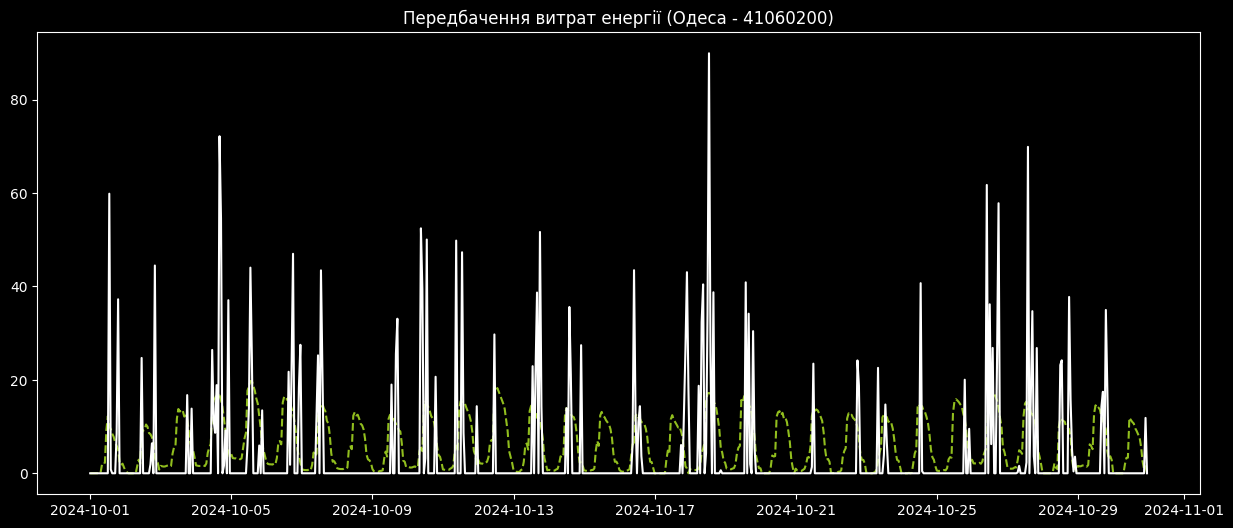

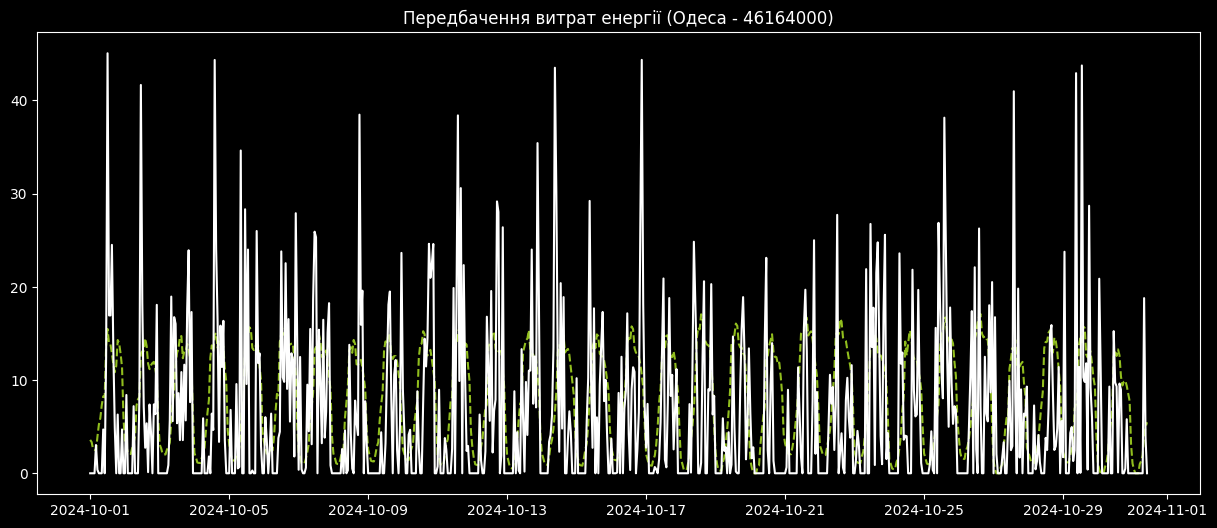

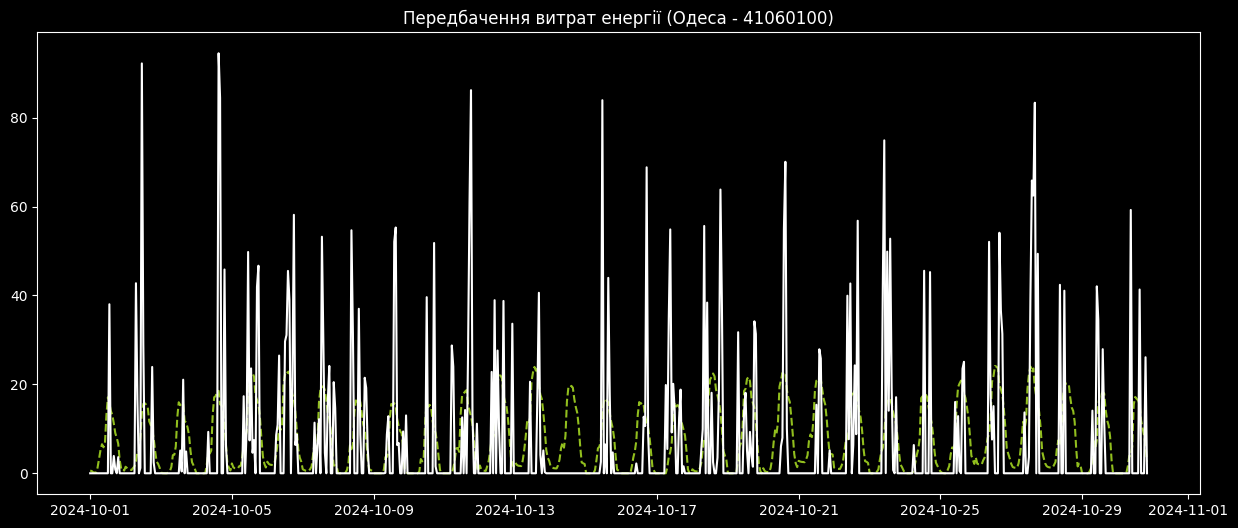

In [239]:
test_odesa = test_odesa.reset_index()
odesa_preds_df = pd.DataFrame(odesa_preds, columns=['preds'])
odesa_preds_df['unicode'] = test_odesa['InternalNum']
odesa_preds_df['time'] = test_odesa['time']
distinct_odesa = test_odesa['InternalNum'].unique()

odesa_station_rmse = {}

for station in distinct_odesa:
    cut_preds = odesa_preds_df[odesa_preds_df['unicode'] == station]
    cut_test = test_odesa[test_odesa['InternalNum'] == station]
    rmse = np.sqrt(mean_squared_error(cut_preds['preds'], cut_test['kWh']))
    odesa_station_rmse[station] = rmse

# Sort stations by RMSE
sorted_stations = sorted(odesa_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = odesa_preds_df[odesa_preds_df['unicode'] == median_station]
cut_test_median = test_odesa[test_odesa['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Одеса - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = odesa_preds_df[odesa_preds_df['unicode'] == best_station]
cut_test_median = test_odesa[test_odesa['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Одеса - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = odesa_preds_df[odesa_preds_df['unicode'] == worst_station]
cut_test_median = test_odesa[test_odesa['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Одеса - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')


<font>
<font size = '10'>
<center><b>Рівне</b></center></font>

In [240]:
rivne_stations['time'] = pd.to_datetime(rivne_stations['time'])

rivne_stations['year'] = rivne_stations['time'].dt.year
rivne_stations['month'] = rivne_stations['time'].dt.month
rivne_stations['day'] = rivne_stations['time'].dt.day
rivne_stations['day_of_week'] = rivne_stations['time'].dt.weekday
rivne_stations['hour'] = rivne_stations['time'].dt.hour

rivne_stations.tail()

# Filter for test (October 2024)
test_rivne = rivne_stations[(rivne_stations['time'].dt.year == 2024) & (rivne_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_rivne = rivne_stations[(rivne_stations['time'].dt.year == 2024) & (rivne_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_rivne = rivne_stations[(rivne_stations['time'] > '2023-01-01') & (rivne_stations['time'] < '2024-09-01')]

X_train = train_rivne[features]
y_train = train_rivne[target]

X_valid = validation_rivne[features]
y_valid = validation_rivne[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\1938884343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rivne_stations['time'] = pd.to_datetime(rivne_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\1938884343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rivne_stations['year'] = rivne_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\1938884343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [241]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-18 15:57:54,068] A new study created in memory with name: no-name-ac6eab17-b60b-41c6-92d3-a3f79a8250a0
[I 2024-12-18 15:57:55,504] Trial 0 finished with value: 19.730007241305028 and parameters: {'n_estimators': 950, 'max_depth': 3, 'learning_rate': 0.22596392615857608, 'subsample': 0.8197379041180215, 'colsample_bytree': 0.5367862027859349, 'gamma': 0.6148742223696624, 'lambda': 0.004000938720385964, 'alpha': 1.0000951255185508}. Best is trial 0 with value: 19.730007241305028.
[I 2024-12-18 15:57:56,068] Trial 1 finished with value: 19.86231406474002 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.1566224833258592, 'subsample': 0.5535186959703795, 'colsample_bytree': 0.5405670347113976, 'gamma': 5.165515280041658, 'lambda': 9.683812311786715, 'alpha': 0.10945426748998657}. Best is trial 0 with value: 19.730007241305028.
[I 2024-12-18 15:57:58,886] Trial 2 finished with value: 21.952939357861517 and parameters: {'n_estimators': 1000, 'max_depth': 9,

Best Parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05373152185375228, 'subsample': 0.673062606301872, 'colsample_bytree': 0.8697232152826475, 'gamma': 1.0708448628341394, 'lambda': 0.0011457307420981015, 'alpha': 0.047328007709696085}
Optimized XGB RMSE: 18.85502914109843


In [242]:
X_test = test_rivne[features]
y_test = test_rivne[target]

rivne_preds = xgb_model_test(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 18.43297846155632


Best RMSE: 6.1139 (Station: 40660900)
Median RMSE: 24.7783 (Station: 40611700)
Worst RMSE: 24.8444 (Station: 40610700)


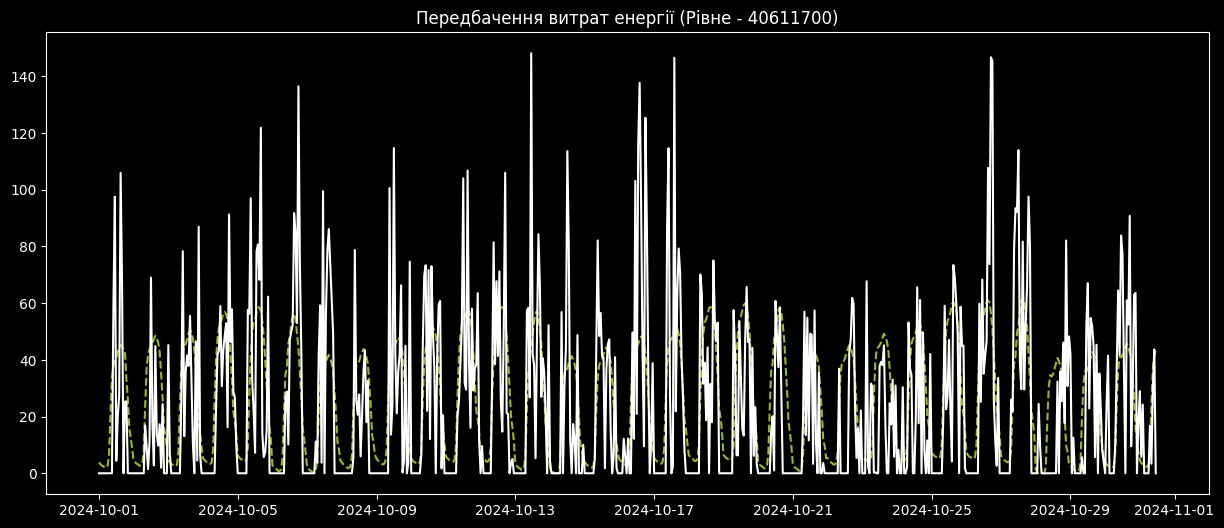

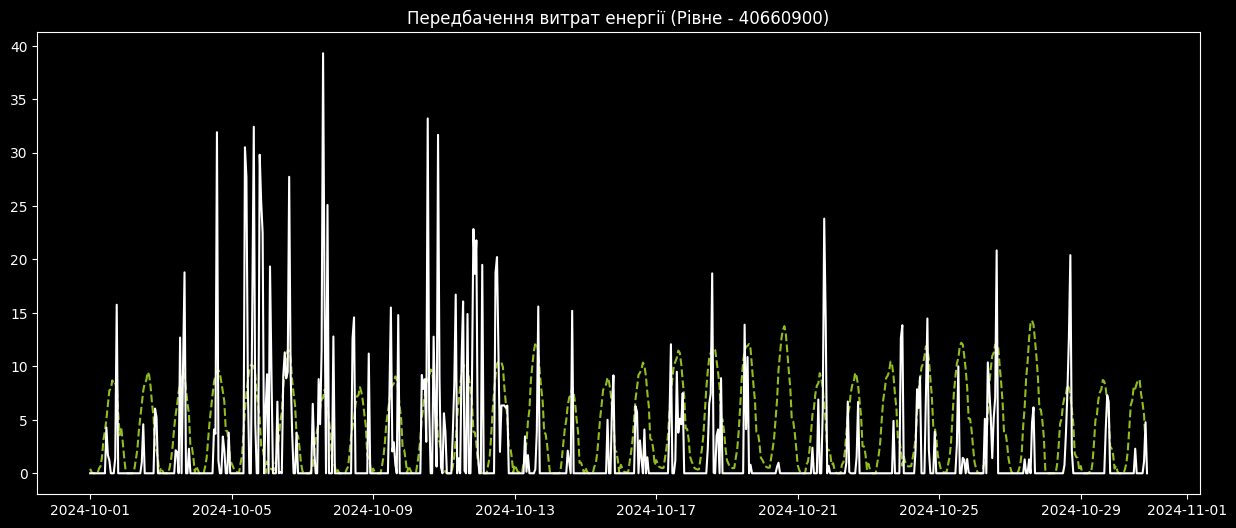

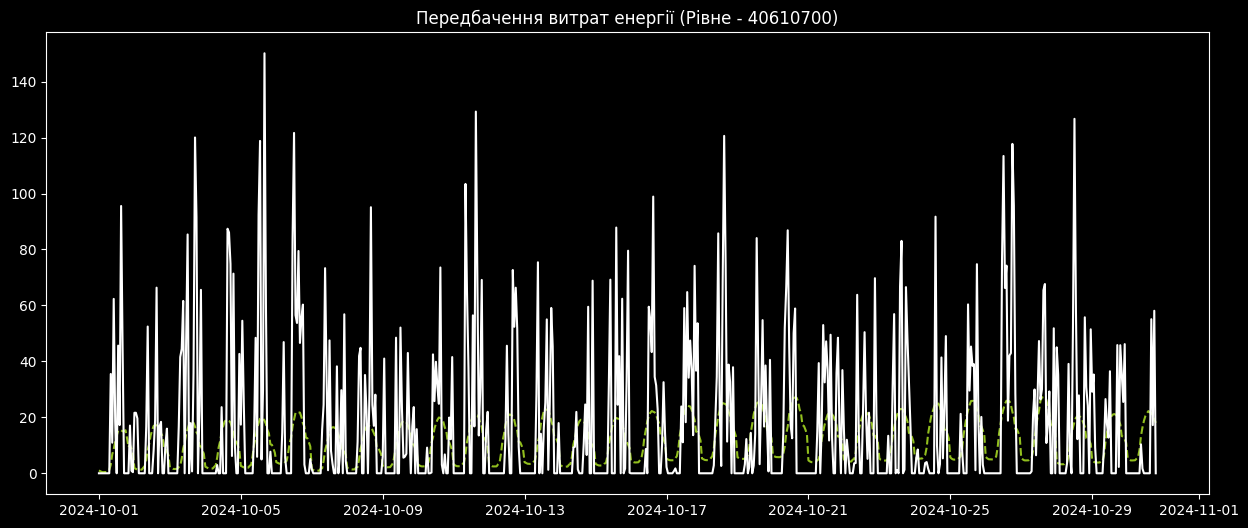

In [243]:
test_rivne = test_rivne.reset_index()
rivne_preds_df = pd.DataFrame(rivne_preds, columns=['preds'])
rivne_preds_df['unicode'] = test_rivne['InternalNum']
rivne_preds_df['time'] = test_rivne['time']
distinct_rivne = test_rivne['InternalNum'].unique()

rivne_station_rmse = {}

for station in distinct_rivne:
    cut_preds = rivne_preds_df[rivne_preds_df['unicode'] == station]
    cut_test = test_rivne[test_rivne['InternalNum'] == station]
    rmse = np.sqrt(mean_squared_error(cut_preds['preds'], cut_test['kWh']))
    rivne_station_rmse[station] = rmse

# Sort stations by RMSE
sorted_stations = sorted(rivne_station_rmse.items(), key=lambda x: x[1])

# Extract best, median, and worst RMSE values
best_station, best_rmse = sorted_stations[0]
median_station, median_rmse = sorted_stations[len(sorted_stations) // 2]
worst_station, worst_rmse = sorted_stations[-1]

# Print results
print(f"Best RMSE: {best_rmse:.4f} (Station: {best_station})")
print(f"Median RMSE: {median_rmse:.4f} (Station: {median_station})")
print(f"Worst RMSE: {worst_rmse:.4f} (Station: {worst_station})")

cut_preds_median = rivne_preds_df[rivne_preds_df['unicode'] == median_station]
cut_test_median = test_rivne[test_rivne['InternalNum'] == median_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Рівне - {median_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = rivne_preds_df[rivne_preds_df['unicode'] == best_station]
cut_test_median = test_rivne[test_rivne['InternalNum'] == best_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Рівне - {best_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')



cut_preds_median = rivne_preds_df[rivne_preds_df['unicode'] == worst_station]
cut_test_median = test_rivne[test_rivne['InternalNum'] == worst_station]

plt.figure(figsize=(15, 6))
plt.title(f'Передбачення витрат енергії (Рівне - {worst_station})')
plt.plot(cut_preds_median['time'], cut_preds_median['preds'], color='#91be1e', linestyle='--')
plt.plot(cut_test_median['time'], cut_test_median['kWh'], color='white')
